# NEURAL MACHINE TRANSLATION USING TRANSFORMER MODEL

Translating from English to Spanish

In [1]:
import tensorflow as tf

from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import preprocessing, utils 
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow_datasets as tfds 
import os
import re
import numpy as np
import string

# Creating datasets for training 

In [2]:
# reading data 
with open('/content/spa.txt', encoding='utf-8', errors='ignore') as file:
  text = file.read().split('\n')


In [3]:
input_texts = []
target_texts = []

In [4]:
# we will select subset of the whole data
NUM_SAMPLES = 10000

for line in text[:NUM_SAMPLES]:
  english, spanish = line.split('\t')[:2]
  target_text = spanish.lower()
  input_texts.append(english.lower())
  target_texts.append(target_text)

#PREPROCESSING

In [5]:
regex = re.compile('[%s]' % re.escape(string.punctuation))
for s in input_texts:
  regex.sub('', s)
for s in target_texts:
  regex.sub('', s)

In [6]:
input_texts[1], target_texts[1]

('go.', 'vete.')

#TOKENIZING AND PADDING

## Use SubwordTextEncoder for both English and Spanish datasets.
The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.

In [7]:
tokenizer_input = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(input_texts, target_vocab_size=2**13)

In [8]:
# example showing how this tokenizer works
tokenized_string1=tokenizer_input.encode('hello i am good')
tokenized_string1

[2269, 1, 41, 89]

In [9]:
for token in tokenized_string1:
  print('{} -----> {}'.format(token, tokenizer_input.decode([token])))

2269 -----> hello 
1 -----> i 
41 -----> am 
89 -----> good


In [10]:
# if the word is not in dictionary
tokenized_string2 = tokenizer_input.encode('how is the moon')
for token in tokenized_string2:
  print('{} -------> {}'.format(token, tokenizer_input.decode([token])))

64 -------> how 
4 -------> is 
21 -------> the 
2827 -------> m
2829 -------> o
75 -------> on


In [11]:
# tokenize Spanish text
tokenizer_out = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(target_texts, target_vocab_size = 2**13)

## Create start and end tokens to both input and target

In [12]:
# the input start token
START_TOKEN_in = [tokenizer_input.vocab_size]
# input end token
END_TOKEN_in = [tokenizer_input.vocab_size+1]
# output start token
START_TOKEN_out = [tokenizer_out.vocab_size]
# output end token
END_TOKEN_out = [tokenizer_out.vocab_size+1]

In [13]:
START_TOKEN_in, END_TOKEN_in, START_TOKEN_out, END_TOKEN_out

([2974], [2975], [5737], [5738])

# Function for tokenizing and padding

In [14]:
MAX_LENGTH = 10

# Tokenize, filter and pad sentences
def tokenize_and_padding(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (input_sentence, output_sentence) in zip(inputs, outputs):
    # tokenize sentence
    input_sentence = START_TOKEN_in + tokenizer_input.encode(input_sentence) + END_TOKEN_in
    output_sentence = START_TOKEN_out + tokenizer_out.encode(output_sentence) + END_TOKEN_out
    # check tokenized sentence max length
    #if len(input_sentence) <= MAX_LENGTH and len(output_sentence) <= MAX_LENGTH:
    tokenized_inputs.append(input_sentence)
    tokenized_outputs.append(output_sentence )
  
  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs





In [15]:
english, spanish = tokenize_and_padding(input_texts, target_texts)

In [16]:
english[1]

array([2974,   50, 2764, 2975,    0,    0,    0,    0,    0,    0],
      dtype=int32)

#PREPARING DATASET FOR TRAINING

In [17]:
BATCH_SIZE = 32
BUFFER_SIZE = 10000

# decoder inputs use the previous target as input,
# remove START_TOKEN from targets

dataset = tf.data.Dataset.from_tensor_slices((
    
    {
        'inputs': english,
        'decoder_inputs': spanish[:, :-1]
    },

    {
        
        'outputs': spanish[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Transformer model 


# MULTIHEAD ATTENTION CLASS


In [18]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model
    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model) 
    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

    

# Scaled dot product attention

In [19]:
def scaled_dot_product_attention(query, key, value, mask):
  QxK_transpose = tf.matmul(query, key, transpose_b=True)

  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = QxK_transpose / tf.math.sqrt(depth)

  if mask is not None:
    logits = logits + (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

# Masking functions

In [20]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence_length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [21]:
# function testing
x = tf.constant([[2974,   50, 2764, 2975,    0,    0,    0,    0,    0,    0]])
create_padding_mask(x)

<tf.Tensor: shape=(1, 1, 1, 10), dtype=float32, numpy=array([[[[0., 0., 0., 0., 1., 1., 1., 1., 1., 1.]]]], dtype=float32)>

In [22]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

#POSITIONAL ENCODING

In [23]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sine to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cosine to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [24]:
x = tf.constant([[1, 2, 3], [4, 5, 6]])
tf.transpose(x)

<tf.Tensor: shape=(3, 2), dtype=int32, numpy=
array([[1, 4],
       [2, 5],
       [3, 6]], dtype=int32)>

In [25]:
x = tf.constant([[[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]]])
tf.transpose(x, perm=[0, 2, 1, 3])

<tf.Tensor: shape=(1, 4, 1, 3), dtype=int32, numpy=
array([[[[ 1,  2,  3]],

        [[ 4,  5,  6]],

        [[ 7,  8,  9]],

        [[10, 11, 12]]]], dtype=int32)>

In [26]:
# if 'input' is 

input = [[ 0,  1,  2, 3],
                 [-1,  0,  1, 2],
                 [-2, -1,  0, 1],
                 [-3, -2, -1, 0]],

tf.linalg.band_part(input, -1, 0) 


<tf.Tensor: shape=(1, 4, 4), dtype=int32, numpy=
array([[[ 0,  0,  0,  0],
        [-1,  0,  0,  0],
        [-2, -1,  0,  0],
        [-3, -2, -1,  0]]], dtype=int32)>

In [27]:
x = tf.constant([0., 0., 0., 0.])
y = tf.constant([-2., 0., 2., 5.])
tf.maximum(x, y)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 2., 5.], dtype=float32)>

# Encoder layer

In [28]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # multi-head attention with padding mask
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # two dense layers followed by a dropout
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

# Encoder

In [29]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  # create padding mask
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # create combination of word embedding + positional encoding
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # repeat the Encoder Layer two times
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

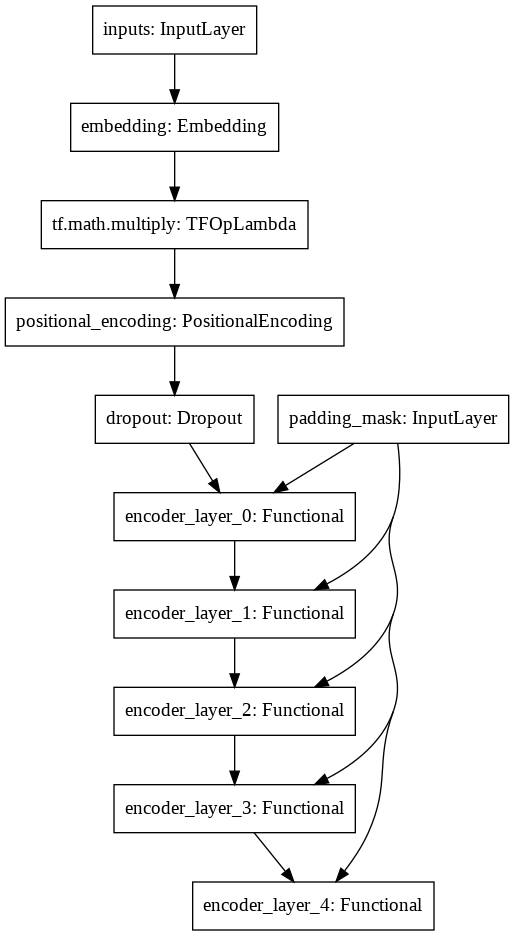

In [30]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=5,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png')

# DECODER LAYER

In [31]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

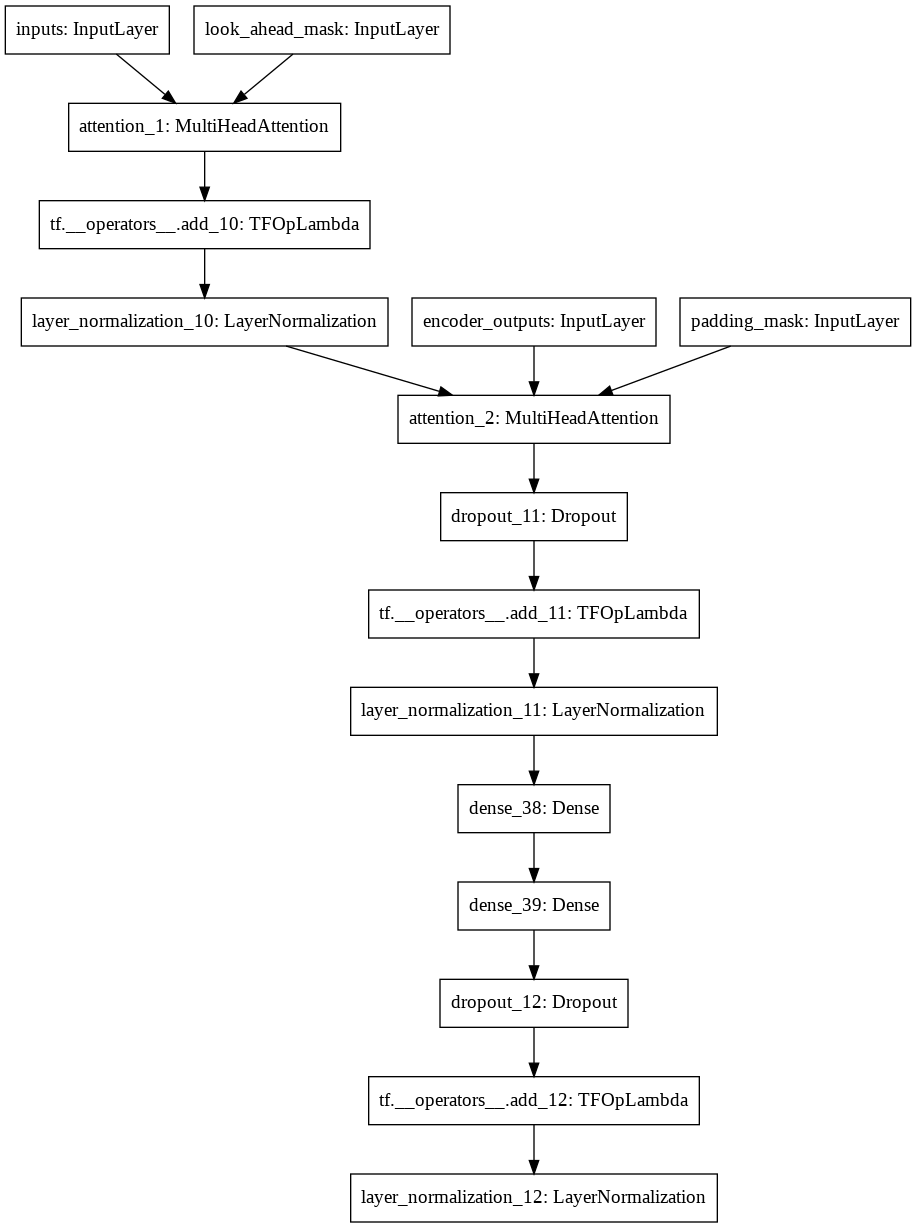

In [32]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png')

# Decoder

### Decoder

The Decoder consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [67]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

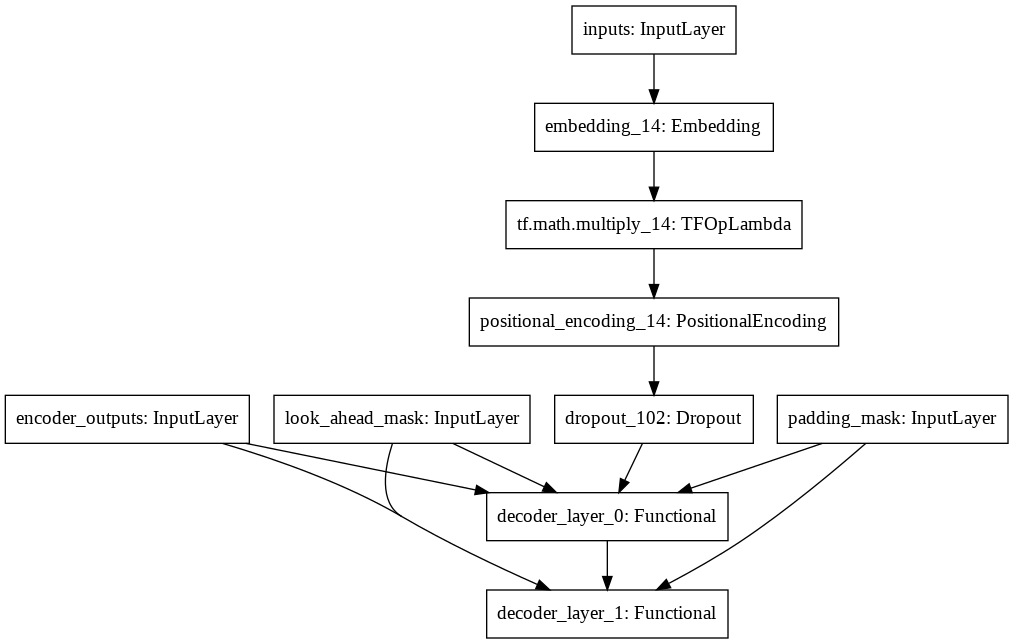

In [68]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png')

# Final Transformer model

Transformer consists of the encoder, decoder and a final linear layer.

In [69]:
def transformer(input_vocab_size,
                target_vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="decoder_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=input_vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=target_vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=target_vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

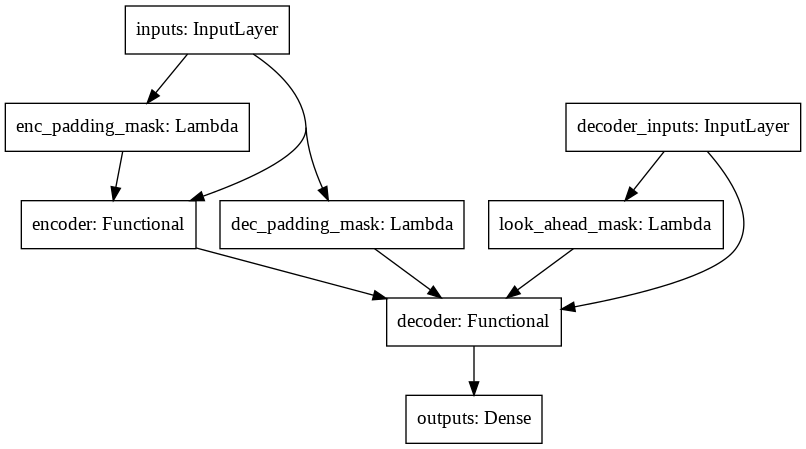

In [70]:
sample_transformer = transformer(
    input_vocab_size = 100,
    target_vocab_size = 100,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png')

#MODEL FOR TRAINING

In [71]:
D_MODEL = 256
model = transformer(
    tokenizer_input.vocab_size+2,
    tokenizer_out.vocab_size+2,
    num_layers = 2,
    units = 512,
    d_model = D_MODEL,
    num_heads = 8,
    dropout = 0.1)

#LOSS FUNCTION

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [72]:
def loss(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, 10 - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

# Optimizer

###Custom LEARNING RATE


$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [73]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [74]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [75]:
model.compile(optimizer=optimizer, loss=loss)

#TRAINING

In [76]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS)

Epoch 1/20
313/313 [==============================] - 83s 241ms/step - loss: 4.3023
Epoch 2/20
313/313 [==============================] - 75s 240ms/step - loss: 2.4805
Epoch 3/20
313/313 [==============================] - 76s 242ms/step - loss: 1.8926
Epoch 4/20
313/313 [==============================] - 75s 241ms/step - loss: 1.5668
Epoch 5/20
313/313 [==============================] - 76s 242ms/step - loss: 1.3235
Epoch 6/20
313/313 [==============================] - 75s 240ms/step - loss: 1.1154
Epoch 7/20
313/313 [==============================] - 76s 242ms/step - loss: 0.9448
Epoch 8/20
313/313 [==============================] - 76s 241ms/step - loss: 0.8081
Epoch 9/20
313/313 [==============================] - 76s 242ms/step - loss: 0.6815
Epoch 10/20
313/313 [==============================] - 75s 240ms/step - loss: 0.5969
Epoch 11/20
313/313 [==============================] - 76s 243ms/step - loss: 0.5341
Epoch 12/20
313/313 [==============================] - 76s 242ms/step - lo

#PREDICTION

In [79]:
def translate(input_sentence):

  input_sentence = START_TOKEN_in + tokenizer_input.encode(input_sentence) + END_TOKEN_in
  encoder_input = tf.expand_dims(input_sentence, 0)

  decoder_input = [tokenizer_out.vocab_size]
  output = tf.expand_dims(decoder_input, 0)

  for ii in range(MAX_LENGTH):
    predictions = model(inputs=[encoder_input, output], training=False)

    # select the last word
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # terminate on END_TOKEN
    if tf.equal(predicted_id, END_TOKEN_out[0]):
      break

    # concatenated the predicted_id to output
    output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

# Testing

In [81]:
test_sentences = ['i am sorry', 'how are you']
for s in test_sentences:
  predictions = translate(s)

  predicted_sentence = tokenizer_out.decode([i for i in predictions if i < tokenizer_out.vocab_size])

  print('Input: {}'.format(s))
  print('Output: {}'.format(predicted_sentence))

Input: i am sorry
Output: lo 
Input: how are you
Output: cómo 
